## Expériences numériques du chapitre 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

### Récupération du schéma via l'opérateur proximal 

**Opérateur proximal de la norme de la norme $\ell_1$ ordonnée :** Cet opérateur est la solution du problème d'optimisation 
$${\rm prox}_{\tau \lambda}(y)=\arg \min_{b\in \mathbb{R}^p} \left\{ \frac{1}{2}\|y-b\|_2^2+\tau J_\lambda(b) \right\}.$$
Une implémentation naïve de cet opérateur est donnée ci-dessous

In [4]:
# La suite de Cesàro permet de déterminer les premiers termes de l'opérateur. 

def Cesaro(y,Lambda):
    p = len(y)
    C = np.cumsum(y-Lambda)/np.linspace(1,p,p)
    k = np.argmax(C)+1
    if C[k] <= 0:
        k = p
        C[-1] = 0
    return C[k-1] , k

# Opérateur proximal lorsque y1 >= ... >= yp >= 0. 

def prox_L1_ordonnee_decroissant(y,Lambda):
    p = len(y)
    prox = np.zeros(p)
    i = 0
    while i<p :
        C, k = Cesaro(y,Lambda)
        prox[i:i+k] = C
        y = y[k:]
        Lambda=Lambda[k:]
        i += k
    return prox
    
# Opérateur proximal pour y quelconque.

def prox_L1_ordonnee(y,Lambda):
    p = len(y)
    prox = np.zeros(p)
    sign = np.sign(y)
    perm = np.argsort(-np.abs(y))
    y = np.abs(y)[perm]
    prox[perm] = prox_L1_ordonnee_decroissant(y,Lambda)
    prox *= sign
    return(prox)

**Implémentation rapide de l'opérateur proximal :** Cet algorithme est basé sur les maximum locaux de la suite de Cesàro et sur le depistage des composantes nulles de l'opérateur proximal. 

In [5]:
def prox_L1_ordonnee_rapide_depistage(y,Lambda):
    Rep=list()
    V=list()
    p=len(y)
    
    y_sign = np.sign(y)
    y = np.abs(y)
    ord = np.argsort(-y)
    y = y[ord]
    
    l = 0 
       
    positif = np.sum(1-np.cumprod(np.flip(y<Lambda)))  # Borne supérieure sur le nombre de composantes non-nulles
    
    if positif <=0:
        return np.zeros(p)
    
    Lambda = y[:positif] - Lambda[:positif] 
    
    while positif>0:
        S = Lambda[0]
        i = 1
        while i<positif and   Lambda[i]  >= S:
            S += Lambda[i]
            i += 1
        Rep.append(i)
        V.append(S/i)
        l += 1 
        Lambda=Lambda[i:]
        positif += -i
        
        while l>1 and V[-1]>V[-2]:
            V[-2]=(Rep[-1]*V[-1]+Rep[-2]*V[-2])/(Rep[-2]+Rep[-1])   
            Rep[-2]+=Rep[-1]
            del V[-1]
            del Rep[-1]
            l += -1
    k=0
    for i in range(l):
        y[k:k+Rep[i]] = max(V[i],0)
        k=k+Rep[i]
    
    y[ord[:k]] =  y[:k].copy()
    y[ord[:k]] *= y_sign[ord[:k]]
    y[ord[k:]] = 0

    return y

**Image du "six" tiré de la base de données MNIST**

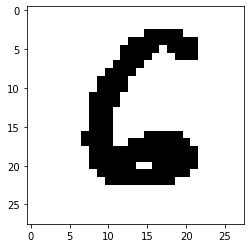

In [6]:
# Position des pixels noirs

ind=np.array([99, 100, 101, 102, 103, 125, 126, 127, 128, 129, 130, 131, 132, 133, 152, 153, 154, 155, 
156, 158, 159, 160, 161, 180, 181, 182, 183, 187, 188, 189, 207, 208, 209, 210, 234, 235, 236, 237, 
261, 262, 263, 264, 289, 290, 291, 292, 316, 317, 318, 319, 344, 345, 346, 347, 372, 373, 374, 400, 
401, 402, 428, 429, 430, 455, 456, 457, 458, 463, 464, 465, 466, 467, 483, 484, 485, 486, 489, 490, 
491, 492, 493, 494, 495, 496, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525,
540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 568, 569, 570, 571, 572, 573, 
576, 577, 578, 579, 580, 581, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 626, 627, 
628, 629, 630, 631, 632, 633, 634])

six=np.zeros(784)
six[ind]=1
image_six=six.reshape(28, 28)
plt.imshow(image_six, cmap="Greys")
plt.show()
plt.close()

**Récupération du schéma lorsque l'image précédente est bruitée**

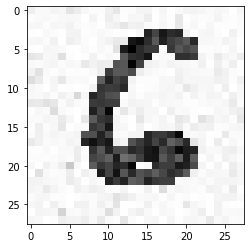

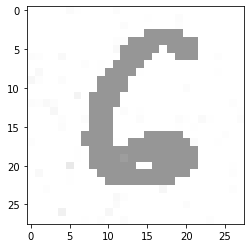

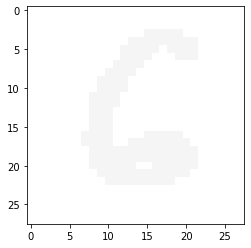

In [7]:
np.random.seed(1) 
I = image_six.flatten() # on vectorialise l'image d chiffre 1
y = I+0.10*np.random.randn(784)
M=max(np.abs(y))

# Représentation graphique de y

plt.imshow(np.abs(y).reshape(28, 28), cmap="Greys", vmin=0,vmax=M)
plt.show()
plt.close()

# On éxécute SLOPE avec le l'hyper-paramètre quasi-sphérique 

Lambda=np.sqrt(range(1,785))-np.sqrt(range(0,784))

# Représentation graphique de l'opérateur proximal lorsque tau = 4,77

tau=4.77
image_six_debruite = prox_L1_ordonnee(y,tau*Lambda)

plt.imshow(np.abs(image_six_debruite).reshape(28, 28), cmap="Greys",vmin=0,vmax=M)
plt.show()
plt.close()


# Représentation graphique de l'opérateur proximal lorsque tau = 10,80

tau=10.80
image_six_debruite = prox_L1_ordonnee(y,tau*Lambda)

plt.imshow(np.abs(image_six_debruite).reshape(28, 28), cmap="Greys",vmin=0,vmax=M)
plt.show()
plt.close()

### Comparaison entre la condition d'irreprésentabilité et condition d'accessibilité

**Condition d'irreprésentabilité du SLOPE :** La condition d'irreprésentabilité est satisfaite pour le schéma $m\in P^{\rm slope}_p$ si
$$X^T\tilde X_m^+ \tilde \lambda_m \in \partial J_\lambda(m) \Leftrightarrow \begin{cases} J_\lambda^*(X^T\tilde X_m^+ \tilde \lambda_m)\le 1 \\
m^TX^T\tilde X_m^+ \tilde \lambda_m=J_\lambda(m)
\end{cases}$$

**Norme $\ell_1$ ordonnée et norme $\ell_1$ ordonnée duale :** C'est normes sont utiles pour tester la condition d'accessibilité 
$$J_\lambda(b)=\sum_{i=1}^{p}\lambda_i|b|_{\downarrow i}\; \text{ et }\;J^*_\lambda(b)=\max\left\{ \frac{|b|_{\downarrow 1}}{\lambda_1}, \frac{|b|_{\downarrow 1}+|b|_{\downarrow 1}}{\lambda_1+\lambda_2},\dots,\frac{|b|_{\downarrow 1}+\dots+|b|_{\downarrow p}}{\lambda_1+\dots+\lambda_p}
\right\}.$$

In [8]:
def norme(b,Lambda):
    b = - np.sort(-np.abs(b))  # b ordonné par valeur absolue décroissante 
    return np.sum(Lambda*b)

def norme_duale(v,Lambda):
    v = - np.sort(-np.abs(v)) # v ordonné par valeur absolue décroissante
    v_cum = np.cumsum(v)  # somme cumulé de v
    Lambda_cum = np.cumsum(Lambda) # somme cumulé de Lambda
    return np.max(v_cum/Lambda_cum)

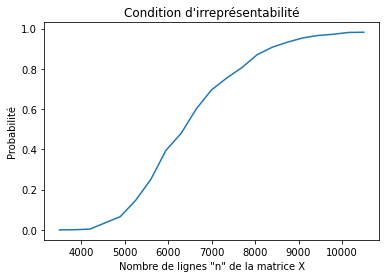

In [12]:
NB=1000 # nombre de simulations pour calculer la probabilité que la condition d'irreprésentabilité soit satisfaite
k=len(ind)
Lambda=np.sqrt(range(1,785))-np.sqrt(range(0,784))
Lambdatilde=np.sum(Lambda[0:k])
N_ci = np.linspace(3500,10500,21,dtype=int)
succes_ci=np.zeros(len(N_ci))
tol = 1e-6

for i in range(len(N_ci)):
    n = N_ci[i]
    for j in range(NB):
        X = np.random.randn(n,784)    
        Xtilde = X @ I
        CI = Lambdatilde * (X.T @ Xtilde) / (Xtilde.T @ Xtilde)
        CI.T @ I - norme(I, Lambda)
        if norme_duale(CI, Lambda)<1+tol and np.abs(CI.T @ I - norme(I, Lambda))<tol:
            succes_ci[i] = succes_ci[i]+1/NB

plt.ylabel('Probabilité')  
plt.xlabel('Nombre de lignes "n" de la matrice X')  # Titre de l'axe x
plt.plot(N_ci, succes_ci)
plt.title('Condition d\'irreprésentabilité')
plt.show()            

**L'algorithme de Douglas Rachford :** Cet algorithme permet de vérifier la condition d'accessibilité et de calculer l'estimateur par récupération $J_\lambda$. 

In [13]:
def DR_SLOPE(A,b,Lambda,rtol=1e-6,it_max=1e2):
    p = A.shape[1]
    y = np.zeros(p)   
    Apsi = np.linalg.pinv(A)
    it = 0
    while True:
        if it >= it_max:
            #print(f"attention : nombre maximal d'itérations atteint ({it_max :.0})")
            break
        if it>=1:
            Jvieux = norme(x,Lambda)
        x = prox_L1_ordonnee_rapide_depistage(y,Lambda)
        #x = prox_SLOPE(y,Lambda)
        z = 2*x-y + Apsi @ (b - A @ (2*x-y))
        y = y + z - x
        if it>=1:
            Jnouv = norme(x,Lambda)
        if it>=1 and np.abs(Jnouv - Jvieux) < rtol*Jnouv:
            #print(f"critère d'arrêt (tolérance relative) satisfait en {it} itérations")
            break
        it = it+1    
    return(x) 

**Condition d'accessibilité :** La condition d'accessibilité est satisfaite pour le schéma $m\in P^{\rm slope}_p$ si $Xm= Xb$ implique  $J_\lambda(b)\ge J_\lambda(m)$.

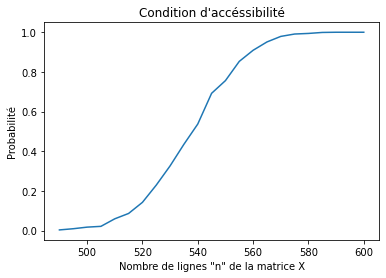

In [14]:
p=784
NB = 1000
N_acc = np.linspace(490,600,23,dtype=int)
succes_acc=np.zeros(len(N_acc))

for i in range(len(N_acc)):
    n = N_acc[i]
    for j in range(NB):
        X=np.random.randn(n,p)    
        Xtilde=X @ I
        Sol_SLOPE = DR_SLOPE(X,Xtilde,Lambda) 
        Arrondi_Sol=np.round(Sol_SLOPE, decimals=0)
        if np.all(Arrondi_Sol == I):
            succes_acc[i]=succes_acc[i]+1/NB   

plt.ylabel('Probabilité')  # Titre de l'axe y
plt.xlabel('Nombre de lignes "n" de la matrice X')  # Titre de l'axe x
plt.plot(N_acc, succes_acc)
plt.title('Condition d\'accéssibilité') # Titre
plt.show()            

**l'algorithme FISTA :** Cet algorithme permet de calculer l'estimateur SLOPE

In [9]:
def FISTA(A, y, Lambda, itmax=1e3, rtol=1e-8):
    def f(x):
        return 0.5*np.linalg.norm(A@x-y, ord = 2)**2
    
    def grad_f(x):
        return A.T@(A@x-y)
        
    p,n = np.shape(A)
    gamma = 1./(np.linalg.norm(A, ord = 2)**2) # calcul de gamma = 1/constante de Lipschitz
    x = np.zeros(n) # vecteur initial x0 
    x_tilde = x # initialisation de x_tilde
    x_old = x # initialisation de x_old = x_k-1
    t = 1. # init de t
    t_old = t # init de t_old = t_k-1
    test = False # initialisation de la condition d'arrêt (convergence)
    F = [f(x)+norme(x,Lambda)] # initialisation de la liste des F(xk)
    
    it = 1
    
    while test == False  and it < itmax: 
        zk = x_tilde - gamma*grad_f(x_tilde) 
        x = prox_L1_ordonnee_rapide_depistage(zk,gamma*Lambda)
        t = 0.5*(1.+ np.sqrt(4.* t**2 + 1.))
        x_tilde = x + ((t_old -1.)/t)*(x-x_old)        
        x_old = x # on fixe xk et tk pour la prochaine iteration
        t_old = t
        F.append(f(x)+norme(x,Lambda)) # on calcule F(xk)
        test = np.abs(F[-1]-F[-2]) < np.abs(F[-1]*rtol) # on vérifie la condition de convergence
        it+=1
    return x,F

**Application de l'opérateur proximal :** Calcul de l'estimateur SLOPE pour un paramètre de régularisation donné et application de l'opérateur proximal de la norme $\ell_1$ ordonnée à cet estimateur. 

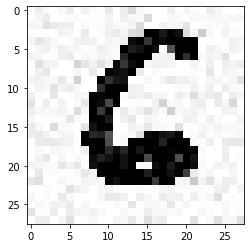

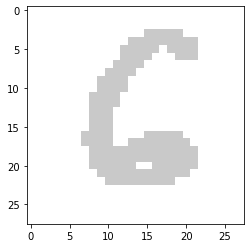

In [10]:
np.random.seed(1) 
n=600
X = np.random.randn(n,784)/np.sqrt(n)
E = 0.05 * np.random.randn(n)
Y = X @ I + E
Lambda=np.sqrt(range(1,785))-np.sqrt(range(0,784))
gmax=norme_duale(X.T @ Y, Lambda)
G = np.exp(np.linspace(-3*np.log(gmax),np.log(gmax),100))
EQM = np.zeros(100)
i=0
for g in G:
    Sol,_ = FISTA(X,Y,g*Lambda)
    EQM[i] = np.linalg.norm(Sol-I,ord=2)**2
    i+=1
i0 = np.argmin(EQM)
Sol0,_ = FISTA(X,Y,G[i0]*Lambda)
M=max(np.abs(Sol0))

#10.527
# 7.0465659212
ratio = 7.0465659212/10.527

tau=ratio*norme_duale(Sol0,Lambda)
prox_Sol0 = prox_L1_ordonnee(Sol0,tau*Lambda)

image_Sol0 = Sol0.reshape(28, 28)
plt.imshow(np.abs(image_Sol0), cmap="Greys",vmin=0,vmax=M)
plt.show()
plt.close()

image_prox_Sol0 = prox_Sol0.reshape(28, 28)
plt.imshow(np.abs(image_prox_Sol0), cmap="Greys",vmin=0,vmax=M)
plt.show()
plt.close()